In [7]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [8]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

# Config

In [15]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/pseud_ashcolor_4label"
    train_label_path = f"{dataset_path}/labels/model2_iter_0/"
    new_label_path = f"{dataset_path}/labels/model2_iter_1/"
    train_model_path = ["/kaggle/working/notebook/experiment/v2/model30/model30/model30.pth",
                        "/kaggle/working/notebook/experiment/v2/model30/model30/model30.pth",
                        "/kaggle/working/notebook/experiment/v2/model30/model30/model30.pth",]
    exp_name = os.getcwd().split('/')[-1]
    exp_description = "model2_iter1"

    # ============== model cfg =============
    model_arch = 'UnetPlusPlus'
    backbone = 'timm-resnest101e'
    in_chans = 3
    target_size = 4
    fold = 3

    # ============== training cfg =============
    train_batch_size = 24
    valid_batch_size = train_batch_size

    epochs = 30
    if debug:
        epochs = 20

    lr = 1e-4
    loss = "DiceLoss"
    smooth = 300

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5, rotate_limit=(10, 10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 300

# Dataset

In [10]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")
valid_df = valid_df.dropna()

train_df_true_label = train_df[~train_df["label_path"].isnull()]
train_df_pseud_label = train_df[train_df["label_path"].isnull()]

fill_path = CFG.train_label_path + train_df["record_id"].astype("str") + "_"+train_df["time"].astype("str")+".npy"
train_df_pseud_label["label_path"] = fill_path

train_df_true_label.loc[:, "fold"] = -1

kf = KFold(n_splits=CFG.fold, random_state=42, shuffle=True)
train_df_pseud_label.loc[:, "fold"] = None
for i, fold in enumerate(kf.split(train_df_pseud_label)):
    train_df_pseud_label["fold"].iloc[fold[1]] = i

train_df = pd.concat([train_df_pseud_label, train_df_true_label], axis=0).sort_values(by=["record_id", "time"]).reset_index(drop=True)

if CFG.debug:
    train_df=train_df[:200]
    valid_df=valid_df[:200]
train_df.shape, valid_df.shape
train_df.head(10)

,record_id,image_path,time,label_path,fold
0,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_0.npy,0
1,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_1.npy,2
2,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_2.npy,2,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_2.npy,2
3,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_3.npy,3,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_3.npy,0
4,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_4.npy,4,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/true/195731008142151_4.npy,-1
5,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_5.npy,5,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_5.npy,2
6,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_6.npy,6,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_6.npy,0
7,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_7.npy,7,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/195731008142151_7.npy,2
8,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/1108741208571075_0.npy,2
9,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model2_iter_0/1108741208571075_1.npy,1



len(dataset_train) = 164232
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([4, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



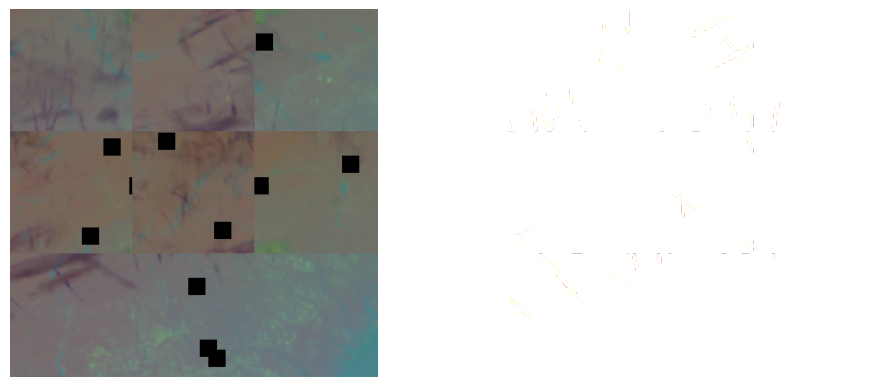

In [11]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list, "pseudo_train")
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list, "pseudo_train")

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(10, dataset_train)

# Training

In [16]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

for fold in range(CFG.fold):
    if fold != 2:continue
    print(f"fold : {fold}\n")
    dataset_train = ContrailsDataset(train_df[train_df["fold"] != fold], CFG.train_aug_list, "pseudo_train")
    dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)

    model, dice_score, thresh = load_model(CFG.train_model_path[fold])
    print(f"model_dice_score:  {dice_score:.4f}")
    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))
    model = nn.DataParallel(model, device_ids=device_ids)

    scaler = amp.GradScaler()
    criterion = smp.losses.DiceLoss(mode="multilabel", smooth=CFG.smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs, eta_min=1e-7)
    thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

    dice_score = 0
    slacknotify=SlackNotify(f"{CFG.exp_description} fold: {fold}")
    for epoch in range(CFG.epochs):
        model.train()

        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
        loss_train, loss_val = 0.0, 0.0
        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                loss_train += loss.detach().item()

            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                  f"Loss: {loss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()

        cum_pred = []
        cum_true = []
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)[:, 2]
                loss_val += criterion(preds, masks).item()
                preds = torch.sigmoid(preds)
                cum_pred.append(preds.cpu().detach().numpy())
                cum_true.append(masks.cpu().detach().numpy())

            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))

        cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
        cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))

        dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)

        if dice_score_ > dice_score:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}\tBEST")
            epoch_best = epoch
            dice_score = dice_score_
            torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                        "model_arch": CFG.model_arch, "backbone": CFG.backbone, "in_chans": CFG.in_chans, "target_size": CFG.target_size,},
                       f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth')
        else:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}")

    slacknotify.send_reply(f" {CFG.exp_description} training finished\tbest score : {dice_score}", True)

fold : 2

model_arch:  UnetPlusPlus
backbone:  timm-resnest101e
model_dice_score:  0.6702


Epoch 0/30  Mem : 21.2GB  LR : 1.00E-04  Loss: 0.2317: 100%|██████████| 4848/4848 [36:34<00:00,  2.21it/s]
Val Loss: 0.0213: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s]


score : 0.6681	thresh : 0.99	SAVED MODEL



Epoch 1/30  Mem : 21.2GB  LR : 9.95E-05  Loss: 0.2310: 100%|██████████| 4848/4848 [36:07<00:00,  2.24it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6642	thresh : 0.69



Epoch 2/30  Mem : 21.2GB  LR : 9.81E-05  Loss: 0.2293: 100%|██████████| 4848/4848 [36:15<00:00,  2.23it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.70it/s]


score : 0.6683	thresh : 0.95	SAVED MODEL



Epoch 3/30  Mem : 21.2GB  LR : 9.62E-05  Loss: 0.2280: 100%|██████████| 4848/4848 [36:15<00:00,  2.23it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6693	thresh : 0.99	SAVED MODEL



Epoch 4/30  Mem : 21.2GB  LR : 9.38E-05  Loss: 0.2277: 100%|██████████| 4848/4848 [36:16<00:00,  2.23it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


score : 0.6692	thresh : 0.27



Epoch 5/30  Mem : 21.2GB  LR : 9.10E-05  Loss: 0.2269: 100%|██████████| 4848/4848 [36:20<00:00,  2.22it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


score : 0.6699	thresh : 0.99	SAVED MODEL



Epoch 6/30  Mem : 21.2GB  LR : 8.77E-05  Loss: 0.2257: 100%|██████████| 4848/4848 [36:23<00:00,  2.22it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s]


score : 0.6677	thresh : 0.71



Epoch 7/30  Mem : 21.2GB  LR : 8.40E-05  Loss: 0.2236: 100%|██████████| 4848/4848 [36:22<00:00,  2.22it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6712	thresh : 0.77	SAVED MODEL



Epoch 8/30  Mem : 21.2GB  LR : 7.99E-05  Loss: 0.2222: 100%|██████████| 4848/4848 [36:20<00:00,  2.22it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


score : 0.6708	thresh : 0.95



Epoch 9/30  Mem : 21.2GB  LR : 7.55E-05  Loss: 0.2210: 100%|██████████| 4848/4848 [36:27<00:00,  2.22it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


score : 0.6686	thresh : 0.91



Epoch 10/30  Mem : 21.2GB  LR : 7.09E-05  Loss: 0.2196: 100%|██████████| 4848/4848 [36:06<00:00,  2.24it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


score : 0.6724	thresh : 0.83	SAVED MODEL



Epoch 11/30  Mem : 21.2GB  LR : 6.60E-05  Loss: 0.2200: 100%|██████████| 4848/4848 [36:09<00:00,  2.23it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


score : 0.6709	thresh : 0.99



Epoch 12/30  Mem : 21.2GB  LR : 6.09E-05  Loss: 0.2190: 100%|██████████| 4848/4848 [36:08<00:00,  2.24it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s]


score : 0.6691	thresh : 0.57



Epoch 13/30  Mem : 21.2GB  LR : 5.58E-05  Loss: 0.2169: 100%|██████████| 4848/4848 [36:07<00:00,  2.24it/s]
Val Loss: 0.0210: 100%|██████████| 78/78 [00:13<00:00,  5.65it/s]


score : 0.6720	thresh : 0.97



Epoch 14/30  Mem : 21.2GB  LR : 5.05E-05  Loss: 0.2171: 100%|██████████| 4848/4848 [36:08<00:00,  2.24it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


score : 0.6726	thresh : 0.17	SAVED MODEL



Epoch 15/30  Mem : 21.2GB  LR : 4.53E-05  Loss: 0.2165: 100%|██████████| 4848/4848 [36:08<00:00,  2.24it/s]
Val Loss: 0.0212: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6728	thresh : 0.99	SAVED MODEL



Epoch 16/30  Mem : 21.2GB  LR : 4.02E-05  Loss: 0.2154: 100%|██████████| 4848/4848 [36:07<00:00,  2.24it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.66it/s]


score : 0.6730	thresh : 0.93	SAVED MODEL



Epoch 17/30  Mem : 21.2GB  LR : 3.51E-05  Loss: 0.2150: 100%|██████████| 4848/4848 [36:07<00:00,  2.24it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.67it/s]


score : 0.6726	thresh : 0.87



Epoch 18/30  Mem : 21.2GB  LR : 3.02E-05  Loss: 0.2146: 100%|██████████| 4848/4848 [36:10<00:00,  2.23it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


score : 0.6727	thresh : 0.95



Epoch 19/30  Mem : 21.2GB  LR : 2.55E-05  Loss: 0.2140: 100%|██████████| 4848/4848 [36:13<00:00,  2.23it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


score : 0.6723	thresh : 0.97



Epoch 20/30  Mem : 21.2GB  LR : 2.11E-05  Loss: 0.2134: 100%|██████████| 4848/4848 [36:12<00:00,  2.23it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.65it/s]


score : 0.6715	thresh : 0.59



Epoch 21/30  Mem : 21.2GB  LR : 1.71E-05  Loss: 0.2129: 100%|██████████| 4848/4848 [36:12<00:00,  2.23it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6726	thresh : 0.75



Epoch 22/30  Mem : 21.2GB  LR : 1.34E-05  Loss: 0.2129: 100%|██████████| 4848/4848 [36:13<00:00,  2.23it/s]
Val Loss: 0.0209: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6732	thresh : 0.97	SAVED MODEL



Epoch 23/30  Mem : 21.2GB  LR : 1.01E-05  Loss: 0.2127: 100%|██████████| 4848/4848 [36:15<00:00,  2.23it/s]
Val Loss: 0.0206: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


score : 0.6736	thresh : 0.81	SAVED MODEL



Epoch 24/30  Mem : 21.2GB  LR : 7.19E-06  Loss: 0.2130: 100%|██████████| 4848/4848 [36:16<00:00,  2.23it/s]
Val Loss: 0.0204: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


score : 0.6718	thresh : 0.03



Epoch 25/30  Mem : 21.2GB  LR : 4.79E-06  Loss: 0.2120: 100%|██████████| 4848/4848 [36:11<00:00,  2.23it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.63it/s]


score : 0.6721	thresh : 0.91



Epoch 26/30  Mem : 21.2GB  LR : 2.89E-06  Loss: 0.2120: 100%|██████████| 4848/4848 [36:13<00:00,  2.23it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.68it/s]


score : 0.6740	thresh : 0.91	SAVED MODEL



Epoch 27/30  Mem : 21.2GB  LR : 1.48E-06  Loss: 0.2129: 100%|██████████| 4848/4848 [36:12<00:00,  2.23it/s]
Val Loss: 0.0207: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


score : 0.6732	thresh : 0.95



Epoch 28/30  Mem : 21.2GB  LR : 5.87E-07  Loss: 0.2114: 100%|██████████| 4848/4848 [36:10<00:00,  2.23it/s]
Val Loss: 0.0208: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


score : 0.6720	thresh : 0.99



Epoch 29/30  Mem : 21.2GB  LR : 1.69E-07  Loss: 0.2123: 100%|██████████| 4848/4848 [36:10<00:00,  2.23it/s]
Val Loss: 0.0202: 100%|██████████| 78/78 [00:13<00:00,  5.70it/s]


score : 0.6719	thresh : 0.27



# Pseudo Labelling

In [ ]:
def pseudo_inference(dataloader_label, model, thresh, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, record_ids, times) in tqdm(enumerate(dataloader_label), total=len(dataloader_label)):
        images = images.cuda()
        with torch.no_grad():
            preds = model(images)
        preds = torch.sigmoid(preds).cpu().detach().numpy()
        preds_thresh = np.where(preds > thresh, 1, 0)

        for num in range(images.shape[0]):
            pred = preds_thresh[num, :, :, :].transpose(1, 2, 0)
            record_id = int(record_ids[num])
            time = int(times[num])
            save_path = f"{save_dir}/{record_id}_{time}.npy"
            np.save(save_path, pred)

In [ ]:
for fold in range(CFG.fold):
    label_df = train_df[train_df["fold"] == fold]

    dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
    dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

    model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[fold]
    model, dice_score, thresh = load_model(model_path)
    model.eval()
    print(f"{dice_score = :.4f}")
    print(f"{thresh = }")

    pseudo_inference(dataloader_label, model, thresh, CFG.new_label_path)

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


100%|██████████| 2246/2246 [1:21:13<00:00,  2.17s/it]  


model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6777
thresh = 0.91


100%|██████████| 2246/2246 [1:10:27<00:00,  1.88s/it]


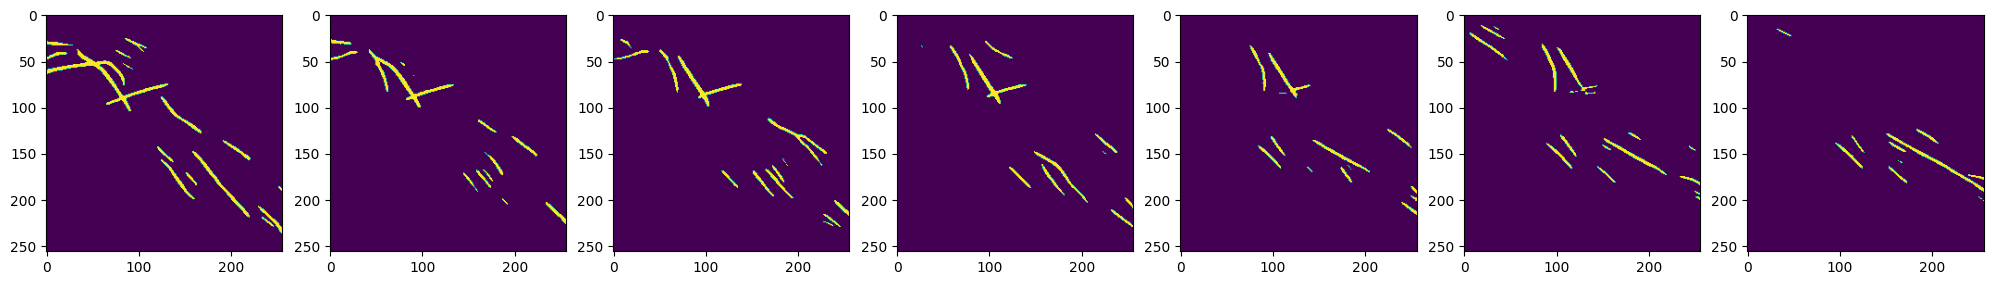

In [18]:
no = 16
id = os.listdir(CFG.new_label_path)[no*7].split("_")[0]
fig, ax = plt.subplots(1, 7, figsize=(25, 10))
for i, time in enumerate([0, 1, 2, 3, 5, 6, 7]):
    npy = np.load(f"{CFG.new_label_path}/{id}_{time}.npy")
    ax[i].imshow(npy)

In [25]:
label_df = train_df[train_df["fold"] == -1]

dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[0]
model, dice_score, thresh = load_model(model_path)
model.eval()
print(f"{dice_score = :.4f}")
print(f"{thresh = }")

pseudo_inference(dataloader_label, model, thresh, "/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/valid")

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


 77%|███████▋  | 494/642 [18:21<05:30,  2.23s/it]


KeyboardInterrupt: 